### 1. Calculate the mass-radius diagrams for models with different polytropic indexes and compare them against each other. Use a parameterization for the EoS of the form $P=k\rho^{1+1/n}$ , and use integer values for as well as  $n=3/2$ . Choose the scale in such a way so that the mass ranges are comparable.

In [1]:
from ipykernel import kernelapp as app
from matplotlib import pyplot as plt    # For plotting things
import numpy as np                      # For mathematical/numerical applications
from scipy.integrate import odeint      # For integrating ODEs
from scipy import optimize
from fractions import Fraction
import sys
import warnings
if not sys.warnoptions: 
    warnings.simplefilter("ignore")


G=1.0                 # Arbitrary units
K=1.0                 # Arbitrary units
Gamma=5.0/3.0

# This defines a function that calculates the derivatives of the system 
# dY/dr = f(Y,r:G,Gamma,K)

# Non Relativistic EOS
def star(y, r, G, Gamma, K):
     return (4.0*np.pi*y[1]*r**2.0, \
             -(G/(K*Gamma))*y[0]*pow(y[1],2.0-Gamma)/r**2.0)   
    
def function1(G,K,n):
    
    Gamma = 1 + 1/n
#     print('-----------------------------')
#     print('n = ',n , 'Gamma = ',Fraction(Gamma).limit_denominator(10))
    
    y0 = (0.0, 1.0)                # This is an array, but not an np.array object    
    
    # try different dr as initial conditions (dr0 = 0.01)
    dr=0.01
    ##display(dr)

    y1 = ((4.0/3.0)*np.pi*y0[1]*dr**3.0, \
          y0[1]-(2.0*np.pi*G/(K*Gamma))*pow(y0[1],3.0-Gamma)*dr**2.0)
    #display(y1)                   # This is our initial guess given by the Teylor expansion

    r1 = np.linspace(dr, 9, 201)                     # This is an np.array object   
    sol = odeint(star, y1, r1, args=(G, Gamma, K))    # This is an np.array object
    
    N = len(sol[:,0])
    order = 4         # polynomial order
    points = order+1
    
    # checking for NaN or Negative values 
    if np.isnan(np.sum(sol[:,1])) : 
        iNaN = sol[:,1].argmax()
        check=1;
        #print(iNaN)
    elif any(sol[:,1]<0) == True :
        iNaN = np.where(sol[:,1]<0)[0][0]
        check=1;
        #print('<0')
    else:
        iNaN = np.argmin(sol[:,1])
        check=0;
    #print('NaN index : ',iNaN)

    # display(sol[:, 0])
    # display(sol[0:iNaN, 1])
    # display(sol.shape)         

    if check==1 :
        # interpolating polynomial coefficients - 4th Order
        pol_coef_rho = np.polyfit(r1[iNaN-points:iNaN],sol[iNaN-points:iNaN,1],order)  
        pol_coef_mass = np.polyfit(r1[iNaN-points:iNaN],sol[iNaN-points:iNaN,0],order)  

        # analytic polynomials
        pr = np.poly1d(pol_coef_rho)
        pm = np.poly1d(pol_coef_mass)

        # root=Rstar
        root = optimize.brent(pr,brack=(r1[iNaN-1],r1[iNaN]))
        #root2 = (polarray[-1,1]*polR[-2]-polarray[-2,1]*polR[-1])/(polarray[-2,1]-polarray[-1,1])
        
        if root > r1[iNaN-1] and root < r1[iNaN] :
            #print('Root found with Polynomial of order: ',order)
            R0 = root
            mass = pm(R0)
            rho_surf = pr(R0)
        else :
            #print('Root found with Bisection')
            R0 = (r1[iNaN-1]+r1[iNaN])/2
            mass = pm(R0)
            rho_surf = pr(R0)
            
        # updating arrays
        sol = np.insert(sol[0:iNaN],0,[[0,1]],axis=0)
        sol = np.append(sol,[[mass,0]],axis=0)

        r = np.insert(r1[0:iNaN],0,0)
        r = np.append(r,R0)
    else :
    # if root is not found, compute until the given limit
        r = r1
        r = np.insert(r,0,0) 
        sol = np.insert(sol,0,y0,axis=0)
        R0 = r[-1]
        mass = sol[-1,0]
        rho_surf = sol[-1,1]
#         print('No Star Surface Until The Given Radius Limit !')
        
    # display(sol[:, 0])
    # display(sol[:, 1])
    # display(sol.shape)
    # display(r)
    
    R_star = R0
    M_star = mass
    
#     print('Results : ')
#     print('Mass =', M_star)
#     print('Radius =', R_star)
#     print('-----------------------------')

    # ---------------------------------------------- PLOTS ----------------------------------------------------

#     plt.figure(figsize=(10, 5), dpi=80)
    plt.xlim(0.0, R_star+dr) 
#     plt.ylim(-0.01, 1.01)     
    dTitle = 'Mass - Radial Profile with : n = ' + str(n) + ', Gamma = ' + str(Fraction(Gamma).limit_denominator(10))
#     plt.suptitle(dTitle, fontsize=18)
    plt.plot(r[:], sol[:,0], label=dTitle)   
    #plt.plot(r[:], sol[:,1],label=dTitle) 

#     plt.legend(loc='best')
#     plt.xlabel('r')
#     plt.grid()
#     plt.show()



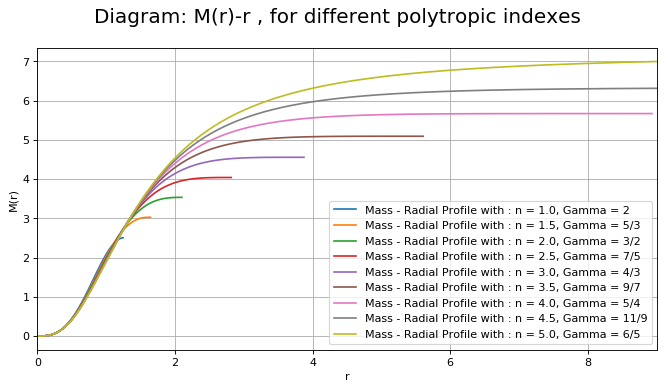

In [2]:
# Run the programm for a variety of G,K,Gamma

nArray = np.array([1, 3/2, 2, 5/2, 3, 7/2, 4, 9/2, 5])
nA = len(nArray)

plt.figure(figsize=(10, 5), dpi=80)
plt.suptitle('Diagram: M(r)-r , for different polytropic indexes', fontsize=18)

for i in range(0,nA):
    function1(1.0,1.0,nArray[i])
    
plt.legend(loc='best')
plt.xlabel('r')
plt.ylabel('M(r)')
plt.grid()
plt.show()

### 2. Using a "relativistic" Eos calculate the Newtonian gravity mass-radius diagram and compare it with the previous results.

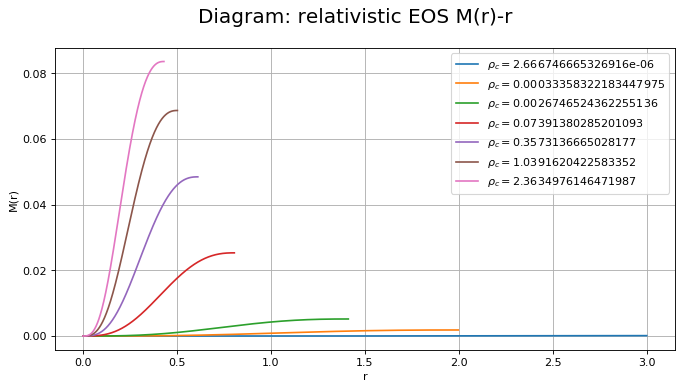

In [3]:
# Relativistic EOS
def star2(y, r, G, K):
     return (4.0*np.pi*( y[1]*np.sqrt(1+y[1]**2.0)*(1+2.0*y[1]**2.0)\
                        -np.log(y[1]+np.sqrt(1+y[1]**2.0)))*r**2.0, \
             -(G/K)*y[0]*pow(8.0*y[1]**4.0/(3.0*np.sqrt(1+y[1]**2.0)),-1.0)\
             *( y[1]*np.sqrt(1+y[1]**2.0)*(1+2.0*y[1]**2.0)\
                        -np.log(y[1]+np.sqrt(1+y[1]**2.0)))/r**2.0)  


# ============ KEEP IN MIND =====================
# y[0] = m , y[1] = x
# sol[0] = m(r) , sol[1] = rho = x(r)
# ===============================================


X = (0.01,0.05,0.1,0.3,0.5,0.7,0.9)

M_plot = []
R_plot = []
rho_c_plot = []    

r_max = 3.0
l = len(X)
r_grid = 10001

plt.figure(figsize=(10, 5), dpi=80)
plt.suptitle('Diagram: relativistic EOS M(r)-r', fontsize=18)

for j in range(0,l):
    y0 = (0.0, X[j])

    r = np.linspace(0, r_max, r_grid)
    dr = r[1]-r[0]

    rho_c = (y0[1]*np.sqrt(1+y0[1]**2.0)*(1+2.0*y0[1]**2.0)\
         -np.log(y0[1]+np.sqrt(1+y0[1]**2.0)))

    y1 = ((4.0/3.0)*np.pi*rho_c*dr**3.0, \
          y0[1]-(2.0*np.pi*G/(3.0*K*8.0*y0[1]**4.0/(3.0*np.pi**2.0*np.sqrt(1+y0[1]**2.0)))\
              *rho_c**2.0*dr**2.0))

    mass_r = [y0[0]]  
    r_coord = [0.0]
    mass_r.append(y1[0])
    r_coord.append(dr)

    i=2
    s=10

    # this loop devides the integration in shorter intervals
    while y1[1] > 0 and s <len(r) :
        r2 = r[i-1:i+1]

        sol_test = odeint(star2, y1, r2, args =(G, K))
        y1 = (sol_test[1,0],sol_test[1,1])

        mass_r.append(sol_test[1,0])
        r_coord.append(r2[1])

        i=i+1
        s=s+1

    R_star = r_coord[-1]
    M_star = mass_r[-1]
    M_plot.append(M_star)
    R_plot.append(R_star)
    
    rho_c_plot.append(rho_c)
#    display(rho_c)
#   r_max = max([R_star, 3.0]) 
    

    plt.plot(r_coord,mass_r,label=r'$ \rho_c = $' + str(rho_c))
    plt.legend(loc='best')
    
plt.xlabel('r')
plt.ylabel('M(r)')
plt.grid()
plt.show()

### 3. Construct a fluid configuration using a mixed polytope (piecewise polytrope). Specifically, try constructing a configuration with an isothermal core and a gas pressure dominated exterior and an isothermal core and a radiation pressure dominated exterior. Plot the mass and density profiles inside the configurations and the overall EoSs for the two cases. Compare the results.

In [4]:
G=1
K=1
n=1 # isothermal gas for n = 1
Gamma = 1 + 1/n

## y0 = [m,rho]
y0 = (0.0, 1.0)              
dr=0.01

y1 = ((4.0/3.0)*np.pi*y0[1]*dr**3.0, y0[1]-(2.0*np.pi*G/(K*Gamma))*pow(y0[1],3.0-Gamma)*dr**2.0)

# critical point where EOS changes
rho_crit = y0[1]/10

r1 = np.linspace(dr, 9, 201)                     
sol = odeint(star, y1, r1, args=(G, Gamma, K))  

N = len(sol[:,0])
order = 4         # polynomial order
points = order+1

# checking for NaN or Negative values 
if np.isnan(np.sum(sol[:,1])) : 
    iNaN = sol[:,1].argmax()
    check=1;
    #print(iNaN)
elif any(sol[:,1]<0) == True :
    iNaN = np.where(sol[:,1]<0)[0][0]
    check=1;
    #print('<0')
else:
    iNaN = np.argmin(sol[:,1])
    check=0;
#print('NaN index : ',iNaN)

# display(sol[:, 0])
# display(sol[0:iNaN, 1])
# display(sol.shape)         

if check==1 :
    # interpolating polynomial coefficients - 4th Order
    pol_coef_rho = np.polyfit(r1[iNaN-points:iNaN],sol[iNaN-points:iNaN,1],order)  
    pol_coef_mass = np.polyfit(r1[iNaN-points:iNaN],sol[iNaN-points:iNaN,0],order)  

    # analytic polynomials
    pr = np.poly1d(pol_coef_rho)
    pm = np.poly1d(pol_coef_mass)

    # root=Rstar
    root = optimize.brent(pr,brack=(r1[iNaN-1],r1[iNaN]))
    #root2 = (polarray[-1,1]*polR[-2]-polarray[-2,1]*polR[-1])/(polarray[-2,1]-polarray[-1,1])

    if root > r1[iNaN-1] and root < r1[iNaN] :
        #print('Root found with Polynomial of order: ',order)
        R0 = root
        mass = pm(R0)
        rho_surf = pr(R0)
    else :
        #print('Root found with Bisection')
        R0 = (r1[iNaN-1]+r1[iNaN])/2
        mass = pm(R0)
        rho_surf = pr(R0)

    # updating arrays
    sol = np.insert(sol[0:iNaN],0,[[0,1]],axis=0)
    sol = np.append(sol,[[mass,0]],axis=0)

    r = np.insert(r1[0:iNaN],0,0)
    r = np.append(r,R0)
else :
# if root is not found, compute until the given limit
    r = r1
    r = np.insert(r,0,0) 
    sol = np.insert(sol,0,y0,axis=0)
    R0 = r[-1]
    mass = sol[-1,0]
    rho_surf = sol[-1,1]
#         print('No Star Surface Until The Given Radius Limit !')

# display(sol[:, 0])
# display(sol[:, 1])
# display(sol.shape)
# display(r)

R_star = R0
M_star = mass

# we now need to find where density gets lower than the critical value
crit_idx = np.where(sol[:,1]<rho_crit)[0][0]

M_interior = sol[0:crit_idx,0]
rho_interior = sol[0:crit_idx,1]
R_interior = r[0:crit_idx]
P_interior = K*rho_interior**Gamma

# calculatin the exterior for 2 cases
y0 = (M_interior[-1],rho_interior[-1])


In [5]:
# case 1 : gas pressure dominated, for n = 3/2
n = 3/2
Gamma = 1 + 1/n
# y1 = ((4.0/3.0)*np.pi*y0[1]*dr**3.0, y0[1]-(2.0*np.pi*G/(K*Gamma))*pow(y0[1],3.0-Gamma)*dr**2.0)

y1 = y0
r1 = np.linspace(R_interior[-1], 9, 201)                     
sol = odeint(star, y1, r1, args=(G, Gamma, K))  

N = len(sol[:,0])
order = 4         # polynomial order
points = order+1

# checking for NaN or Negative values 
if np.isnan(np.sum(sol[:,1])) : 
    iNaN = sol[:,1].argmax()
    check=1;
    #print(iNaN)
elif any(sol[:,1]<0) == True :
    iNaN = np.where(sol[:,1]<0)[0][0]
    check=1;
    #print('<0')
else:
    iNaN = np.argmin(sol[:,1])
    check=0;
#print('NaN index : ',iNaN)

# display(sol[:, 0])
# display(sol[0:iNaN, 1])
# display(sol.shape)         

if check==1 :
    # interpolating polynomial coefficients - 4th Order
    pol_coef_rho = np.polyfit(r1[iNaN-points:iNaN],sol[iNaN-points:iNaN,1],order)  
    pol_coef_mass = np.polyfit(r1[iNaN-points:iNaN],sol[iNaN-points:iNaN,0],order) 

    # analytic polynomials
    pr = np.poly1d(pol_coef_rho)
    pm = np.poly1d(pol_coef_mass)

    # root=Rstar
    root = optimize.brent(pr,brack=(r1[iNaN-1],r1[iNaN]))
    #root2 = (polarray[-1,1]*polR[-2]-polarray[-2,1]*polR[-1])/(polarray[-2,1]-polarray[-1,1])

    if root > r1[iNaN-1] and root < r1[iNaN] :
        #print('Root found with Polynomial of order: ',order)
        R0 = root
        mass = pm(R0)
        rho_surf = pr(R0)
    else :
        #print('Root found with Bisection')
        R0 = (r1[iNaN-1]+r1[iNaN])/2
        mass = pm(R0)
        rho_surf = pr(R0)

    # updating arrays
#     sol = np.insert(sol[0:iNaN],axis=0)
    sol = np.append(sol,[[mass,0]],axis=0)
    
    # reseting arrays 
    r = r1[0:iNaN]
    r = np.append(r,R0)
else :
# if root is not found, compute until the given limit
    r = r1
    sol = np.insert(sol,0,y0,axis=0)
    R0 = r[-1]
    mass = sol[-1,0]
    rho_surf = sol[-1,1]
    
# full arrays for 1st case
R1 = np.append(R_interior[:],r[:])

M1 = np.append(M_interior[:],sol[0:iNaN,0])
M1 = np.append(M1,mass)

Rho1 = np.append(rho_interior[:],sol[0:iNaN,1])
Rho1 = np.append(Rho1,rho_surf)

tmpP = K*sol[0,1]**Gamma - P_interior[-1] #offset
P1 = P_interior[:]+tmpP
P1 = np.append(P1,K*sol[0:iNaN,1]**Gamma)
P1 = np.append(P1,0)

In [6]:
# case 2 : radiation pressure dominated, for n = 3
n = 3
Gamma = 1 + 1/n
# y1 = ((4.0/3.0)*np.pi*y0[1]*dr**3.0, y0[1]-(2.0*np.pi*G/(K*Gamma))*pow(y0[1],3.0-Gamma)*dr**2.0)

y1 = y0
r1 = np.linspace(R_interior[-1], 9, 201)                     
sol = odeint(star, y1, r1, args=(G, Gamma, K))  

N = len(sol[:,0])
order = 4         # polynomial order
points = order+1

# checking for NaN or Negative values 
if np.isnan(np.sum(sol[:,1])) : 
    iNaN = sol[:,1].argmax()
    check=1;
    #print(iNaN)
elif any(sol[:,1]<0) == True :
    iNaN = np.where(sol[:,1]<0)[0][0]
    check=1;
    #print('<0')
else:
    iNaN = np.argmin(sol[:,1])
    check=0;
#print('NaN index : ',iNaN)

# display(sol[:, 0])
# display(sol[0:iNaN, 1])
# display(sol.shape)         

if check==1 :
    # interpolating polynomial coefficients - 4th Order
    pol_coef_rho = np.polyfit(r1[iNaN-points:iNaN],sol[iNaN-points:iNaN,1],order)  
    pol_coef_mass = np.polyfit(r1[iNaN-points:iNaN],sol[iNaN-points:iNaN,0],order)  

    # analytic polynomials
    pr = np.poly1d(pol_coef_rho)
    pm = np.poly1d(pol_coef_mass)

    # root=Rstar
    root = optimize.brent(pr,brack=(r1[iNaN-1],r1[iNaN]))
    #root2 = (polarray[-1,1]*polR[-2]-polarray[-2,1]*polR[-1])/(polarray[-2,1]-polarray[-1,1])

    if root > r1[iNaN-1] and root < r1[iNaN] :
        #print('Root found with Polynomial of order: ',order)
        R0 = root
        mass = pm(R0)
        rho_surf = pr(R0)
    else :
        #print('Root found with Bisection')
        R0 = (r1[iNaN-1]+r1[iNaN])/2
        mass = pm(R0)
        rho_surf = pr(R0)

    # updating arrays
    #sol = np.insert(sol[0:iNaN],0,[[0,1]],axis=0)
    sol = np.append(sol,[[mass,0]],axis=0)
    
    # reseting arrays 
    r = r1[0:iNaN]
    r = np.append(r,R0)
else :
# if root is not found, compute until the given limit
    r = r1
#     sol = np.insert(sol,0,y0,axis=0)
    R0 = r[-1]
    mass = sol[-1,0]
    rho_surf = sol[-1,1]
    
# full arrays for 2nd case
R2 = np.append(R_interior[:],r[:])

M2 = np.append(M_interior[:],sol[0:iNaN,0])
M2 = np.append(M2,mass)

Rho2 = np.append(rho_interior[:],sol[0:iNaN,1])
Rho2 = np.append(Rho2,rho_surf)

tmpP = K*sol[0,1]**Gamma - P_interior[-1] #offset 
P2 = P_interior[:]+tmpP
P2 = np.append(P2,K*sol[0:iNaN,1]**Gamma)
P2 = np.append(P2,0)

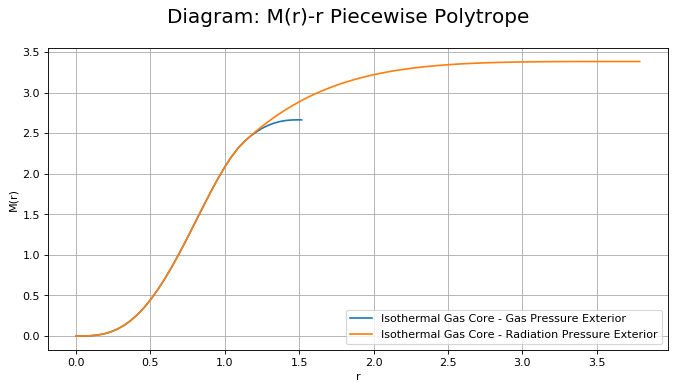

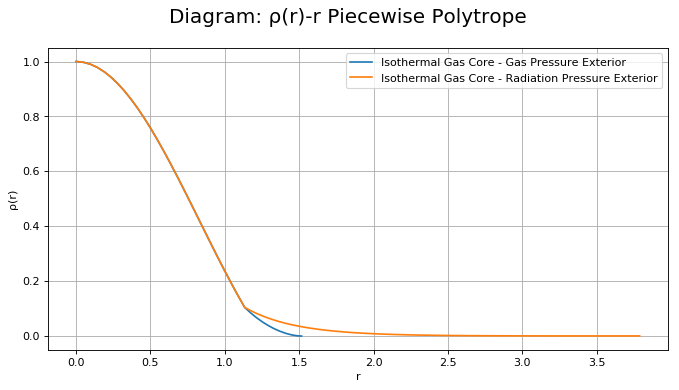

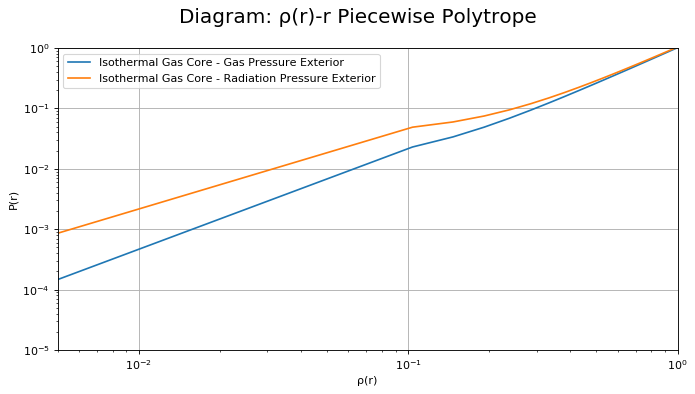

In [7]:
# comparable plots for 2 piecewise polytrope cases

plt.figure(figsize=(10, 5), dpi=80)
plt.suptitle('Diagram: M(r)-r Piecewise Polytrope', fontsize=18)
plt.plot(R1,M1,label='Isothermal Gas Core - Gas Pressure Exterior')
plt.plot(R2,M2,label='Isothermal Gas Core - Radiation Pressure Exterior')
plt.legend(loc='best')
plt.xlabel('r')
plt.ylabel('M(r)')
plt.grid()
plt.show()

plt.figure(figsize=(10, 5), dpi=80)
plt.suptitle('Diagram: ρ(r)-r Piecewise Polytrope', fontsize=18)
plt.plot(R1,Rho1,label='Isothermal Gas Core - Gas Pressure Exterior')
plt.plot(R2,Rho2,label='Isothermal Gas Core - Radiation Pressure Exterior')
plt.legend(loc='best')
plt.xlabel('r')
plt.ylabel('ρ(r)')
plt.grid()
plt.show()

### THIS ONE HAS ISSUES !!!!
plt.figure(figsize=(10, 5), dpi=80)
plt.suptitle('Diagram: ρ(r)-r Piecewise Polytrope', fontsize=18)
plt.loglog(Rho1,P1,label='Isothermal Gas Core - Gas Pressure Exterior')
plt.loglog(Rho2,P2,label='Isothermal Gas Core - Radiation Pressure Exterior')
plt.legend(loc='best')
plt.xlim(0.005, 1)
plt.ylim(10**(-5),1)
plt.xlabel('ρ(r)')
plt.ylabel('P(r)')
plt.grid()
plt.show()

### 4. For the different polytropes and the Fermi gas ("relativistic" Eos), calculate the frequencies and estimate the stability using the various methods we've discussed.

Mass = 2.5066240314905537
Radius = 1.2533855585198403


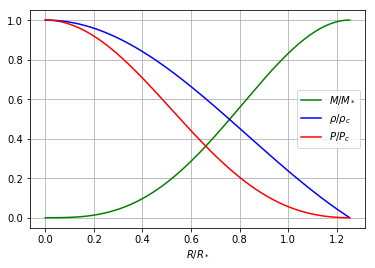

In [48]:
from ipykernel import kernelapp as app
from matplotlib import pyplot as plt    
import numpy as np                      
from scipy.integrate import odeint 
from scipy import optimize
from fractions import Fraction
import math

import sys
import warnings
if not sys.warnoptions: 
    warnings.simplefilter("ignore")
from IPython.display import display, clear_output  
# First we construct our equilibrium model

n = 1.0  
l = 1.0
K = 1.0
G = 1.0

alpha = pow((1.0+n)*K/(G*4.0*np.pi),0.5)

def starLE(y, r, n, l):
     return (-pow(y[1],n)*r**2.0, l*y[0]/r**2.0,)   
    
    
y0 = (0.0, 1.0)     # This is the initial conditions vector (w_c, \theta_c)


r = np.linspace(0, 4, 5001)        # This is an np.array object that creates the 
                                   # integration grid

dr=r[1]-r[0]
#display(dr)

# Here we go straight to calculating the first point

y1 = (-(1.0/3.0)*dr**3.0, 1.0-(1.0/6.0)*dr**2.0)
#display(y1)

r1 = np.linspace(dr, 4, 5001)                      # This is an np.array object

n = 1.0                                          # Setting the polytropic index
soln10 = odeint(starLE, y1, r1, args =(n, l)) 

y01 = np.array([[y0[0], y0[1]]])                # This is an np.array object
# display(y01.shape)

r0 = np.array([0.0])                        # This is an np.array object


r = np.hstack([r0,r1])
# display(r)

sol_n10 = np.vstack([y01,soln10])

i=0
while list(sol_n10[:, 1])[i]>0 :       # surface finder loop
    i=i+1

r_max_in = i

#display(r_max_in)
#display(sol_n10[r_max_in, 1])
                                    # we define the equilibrium parameters
rho_10_eq = pow(sol_n10[:, 1],1.0)
P_10_eq = K*pow(sol_n10[:, 1],2.0)
m_10_eq = - 4.0*np.pi*pow(alpha,3.0)*sol_n10[:, 0]
r_10_eq = alpha*r

M_tot = m_10_eq[r_max_in]
R_tot = r_10_eq[r_max_in]

#display(M_tot)
#display(R_tot)
print('Mass =', M_tot)
print('Radius =', R_tot)

plt.plot(r_10_eq[0:r_max_in], m_10_eq[0:r_max_in]/M_tot, \
                             'g', label=r'$M/M_*$') 
plt.plot(r_10_eq[0:r_max_in], rho_10_eq[0:r_max_in]/rho_10_eq[0], \
                             'b', label=r'$\rho/\rho_c$')
plt.plot(r_10_eq[0:r_max_in], P_10_eq[0:r_max_in]/P_10_eq[0], 'r', \
                                label=r'$P/P_c$')

plt.legend(loc='best')
plt.xlabel(r'$R/R_*$')
# plt.ylabel(r'$M/M_*$')
plt.grid()
plt.show()

### 5. Consider the case of a Fermi gas of neutrons and assume that the local equation of state for the perturbations follows the same equation of state as the star. Calculate the frequency of the fundamental mode for various models along the mass radius diagram. What do you observe?

In [49]:
# Here we will shoot for the boundary condition at the surface
# by solving the initial value problem.
# The shot for eigenvalues will be the roots of the pressure 
# perturbation as a function of $\omega$, $d(\omega)=0$.

def freq_function(ga):

    gamma_ad = ga # adiabatic indices
    omega_n_tt = np.linspace(0.01, 10, 1001)


    def radialOsc(y,  r_eq, m, rho, P, gamma_ad, omega_n, G):
         return (-(3.0*y[0]+y[1])/r_eq, (rho/(gamma_ad*P))*(4.0*G*m/r_eq**2.0\
                            +pow(omega_n,2.0)*r_eq)*y[0]+(rho*G*m/(P*r_eq**2.0))*y[1])

    boundary = []  
    omega_n_t = []

    j=1
    while j < omega_n_tt.size :    
        a_0 = 1.0
        a_2 = -(1.0/10.0)*(rho_10_eq[0]/(gamma_ad*P_10_eq[0]))*(pow(omega_n_tt,2.0)\
                            +(4.0-3.0*gamma_ad)*(4.0*np.pi/3.0)*G*rho_10_eq[0])*a_0

        y0 = (1.0,-3.0)

        dr = r_10_eq[1]-r_10_eq[0]

        y1 = (a_0+a_2[1]*dr**2.0, -3.0*a_0-5.0*a_2[1]*dr**2.0)

        r1 = r_10_eq[1:r_max_in+1]

        omega_n_tt2 = omega_n_tt[j]

                        # Here we solve the perturbation equation step by step.
                        # This is done because the equilibirum quantities are
                        # given in a tabulated form.
                        # One way to go around this could be to interpolate the
                        # relevant functions.

        i=1
        while i < r_max_in :
            m_10_eq2 = m_10_eq[i] 
            rho_10_eq2 = rho_10_eq[i] 
            P_10_eq2 = P_10_eq[i]
            r2 = r1[i-1:i+1]

            soln10_pert = odeint(radialOsc, y1, r2, args =(m_10_eq2, rho_10_eq2, \
                                                P_10_eq2, gamma_ad, omega_n_tt2, G))
            #display(soln10_pert[:,0])
            #display(soln10_pert[:,1])
            y1 = (soln10_pert[1,0],soln10_pert[1,1])
            #display(y1)
            #display(soln10_pert[:,1])
            i=i+1

        boundary.append(soln10_pert[1,1])
        omega_n_t.append(omega_n_tt2) 
        j=j+1        



    # display(boundary)
    dTitle = ' Gamma = ' + str(Fraction(gamma_ad).limit_denominator(10))
    plt.suptitle(dTitle, fontsize=18)
    plt.plot(omega_n_t, boundary, 'g', label=r'$M/M_*$')

    plt.xlabel(r'$\omega$')
    plt.ylabel(r'$d$')
    # plt.ylabel(r'$M/M_*$')
    plt.grid()
    plt.show()

    # ======================================================================================= # 
    # ============================ PART 2 =================================================== # 
    # From these roots we can calculate the eigenfunctions.
    # ======================================================================================= # 
    from IPython.display import display, Math, Latex

    i=1

    while boundary[i]*boundary[i-1]>0 :
        i=i+1

    display(i)
    #display(boundary[i-1])
    #display(boundary[i])
    #display(omega_n_t[i-1])#/(4.0*np.pi))

    omega_n_tt2 = (omega_n_t[i]+omega_n_t[i-1])/2.0

    omega_0 = omega_n_tt2

    a_0 = 0.1
    a_2 = -(1.0/10.0)*(rho_10_eq[0]/(gamma_ad*P_10_eq[0]))*(pow(omega_n_tt2,2.0)\
                            +(4.0-3.0*gamma_ad)*(4.0*np.pi/3.0)*G*rho_10_eq[0])*a_0
    y0 = (a_0,-3.0*a_0)
    dr = r_10_eq[1]-r_10_eq[0]

    y1 = (a_0+a_2*dr**2.0, -3.0*a_0-5.0*a_2*dr**2.0)

    r1 = r_10_eq[2:r_max_in+1]


    x_pert = []
    d_pert = []
    r_pert = []

    j=2
    while j < r_max_in-1 :
        m_10_eq2 = m_10_eq[j] 
        rho_10_eq2 = rho_10_eq[j] 
        P_10_eq2 = P_10_eq[j]
        r2 = r1[j-1:j+1]

        soln10_pert = odeint(radialOsc, y1, r2, \
          args =(m_10_eq2, rho_10_eq2, P_10_eq2, gamma_ad, omega_n_tt2, G))
            #display(soln10_pert[:,0])
            #display(soln10_pert[:,1])
        y1 = (soln10_pert[1,0],soln10_pert[1,1])
            #display(y1)
            #display(soln10_pert[:,1])
        x_pert.append(soln10_pert[1,0])
        d_pert.append(soln10_pert[1,1])
        r_pert.append(r2[1])
        j=j+1

    i=i+1

    while boundary[i]*boundary[i-1]>0 :
        i=i+1

    display(i)
    #display(boundary[i-1])
    #display(boundary[i])
    #display(omega_n_t[i-1])#/(4.0*np.pi))


    omega_n_tt2 = (omega_n_t[i]+omega_n_t[i-1])/2.0

    omega_1 = omega_n_tt2

    a_0 = 0.1
    a_2 = -(1.0/10.0)*(rho_10_eq[0]/(gamma_ad*P_10_eq[0]))*(pow(omega_n_tt2,2.0)\
                            +(4.0-3.0*gamma_ad)*(4.0*np.pi/3.0)*G*rho_10_eq[0])*a_0
    y0 = (a_0,-3.0*a_0)
    dr = r_10_eq[1]-r_10_eq[0]

    y1 = (a_0+a_2*dr**2.0, -3.0*a_0-5.0*a_2*dr**2.0)

    r1 = r_10_eq[2:r_max_in+1]


    x_pert2 = []
    d_pert2 = []
    r_pert2 = []

    j=2
    while j < r_max_in-1 :
        m_10_eq2 = m_10_eq[j] 
        rho_10_eq2 = rho_10_eq[j] 
        P_10_eq2 = P_10_eq[j]
        r2 = r1[j-1:j+1]

        soln10_pert = odeint(radialOsc, y1, r2, \
         args =(m_10_eq2, rho_10_eq2, P_10_eq2, gamma_ad, omega_n_tt2, G))
            #display(soln10_pert[:,0])
            #display(soln10_pert[:,1])
        y1 = (soln10_pert[1,0],soln10_pert[1,1])
            #display(y1)
            #display(soln10_pert[:,1])
        x_pert2.append(soln10_pert[1,0])
        d_pert2.append(soln10_pert[1,1])
        r_pert2.append(r2[1])
        j=j+1


    i=i+1

    while boundary[i]*boundary[i-1]>0 :
        i=i+1

    display(i)
    #display(boundary[i-1])
    #display(boundary[i])
    #display(omega_n_t[i-1])#/(4.0*np.pi))

    omega_n_tt2 = (omega_n_t[i]+omega_n_t[i-1])/2.0

    omega_2 = omega_n_tt2

    a_0 = 0.1
    a_2 = -(1.0/10.0)*(rho_10_eq[0]/(gamma_ad*P_10_eq[0]))*(pow(omega_n_tt2,2.0)\
                            +(4.0-3.0*gamma_ad)*(4.0*np.pi/3.0)*G*rho_10_eq[0])*a_0
    y0 = (a_0,-3.0*a_0)
    dr = r_10_eq[1]-r_10_eq[0]

    y1 = (a_0+a_2*dr**2.0, -3.0*a_0-5.0*a_2*dr**2.0)

    r1 = r_10_eq[2:r_max_in+1]


    x_pert3 = []
    d_pert3 = []
    r_pert3 = []

    j=2
    while j < r_max_in-1 :
        m_10_eq2 = m_10_eq[j] 
        rho_10_eq2 = rho_10_eq[j] 
        P_10_eq2 = P_10_eq[j]
        r2 = r1[j-1:j+1]

        soln10_pert = odeint(radialOsc, y1, r2, \
         args =(m_10_eq2, rho_10_eq2, P_10_eq2, gamma_ad, omega_n_tt2, G))
            #display(soln10_pert[:,0])
            #display(soln10_pert[:,1])
        y1 = (soln10_pert[1,0],soln10_pert[1,1])
            #display(y1)
            #display(soln10_pert[:,1])
        x_pert3.append(soln10_pert[1,0])
        d_pert3.append(soln10_pert[1,1])
        r_pert3.append(r2[1])
        j=j+1


    plt.figure(figsize=(10, 5), dpi=80)
    plt.xlim(0.0, 1.0) 
    plt.ylim(-0.2, 0.2) 
    dTitle = ' Gamma = ' + str(Fraction(gamma_ad).limit_denominator(10))
    plt.suptitle(dTitle, fontsize=18)

    plt.plot(r_pert/R_tot, x_pert, 'g', \
             label=r'$x_0$, $\omega_0^2$= '+str(omega_0**2.0))
    plt.plot(r_pert2/R_tot, x_pert2, 'b', \
             label=r'$x_1$, $\omega_1^2$= '+str(omega_1**2.0))
    plt.plot(r_pert3/R_tot, x_pert3, 'r', \
             label=r'$x_2$, $\omega_2^2$= '+str(omega_2**2.0))

    #display(r_pert2)
    plt.legend(loc='best')

    plt.xlabel(r'$r/R_*$')
    plt.ylabel(r'$x_n$')
    # plt.ylabel(r'$M/M_*$')
    plt.grid()   
    plt.show() 

    display(Math(r'\frac{\omega_0^2}{4\pi} ='+str(omega_0**2.0/(4.0*np.pi))))
    display(Math(r'\frac{\omega_1^2}{4\pi} ='+str(omega_1**2.0/(4.0*np.pi))))
    display(Math(r'\frac{\omega_2^2}{4\pi} ='+str(omega_2**2.0/(4.0*np.pi))))

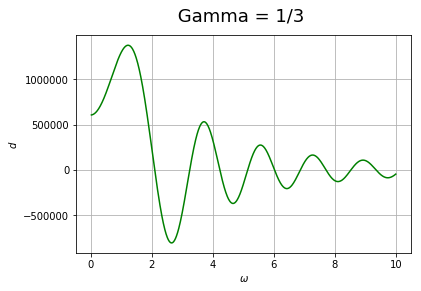

208

323

422

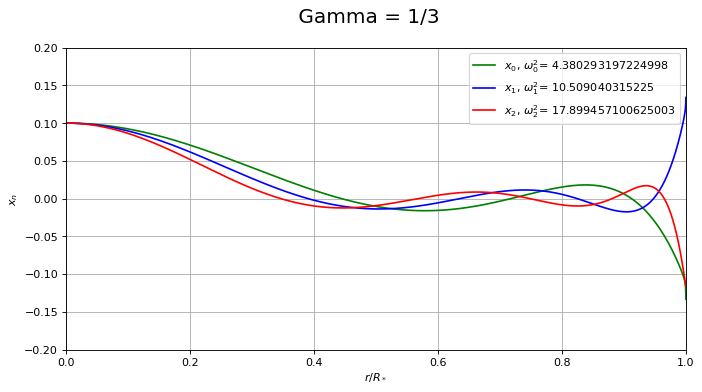

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

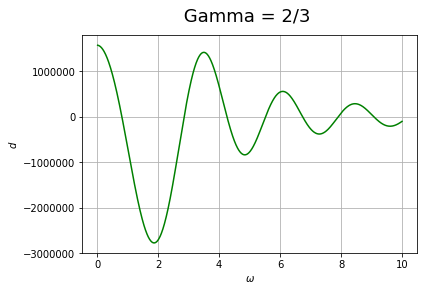

80

284

425

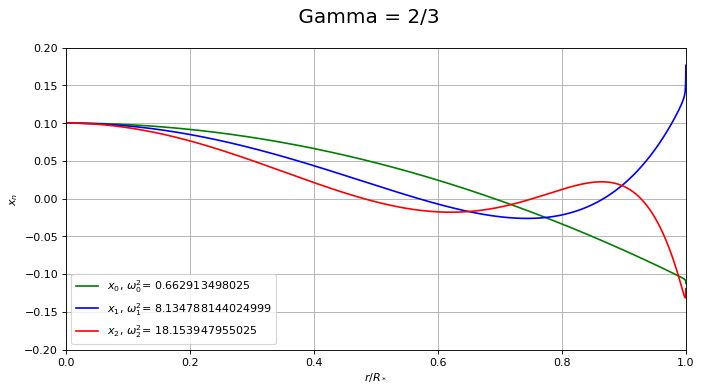

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

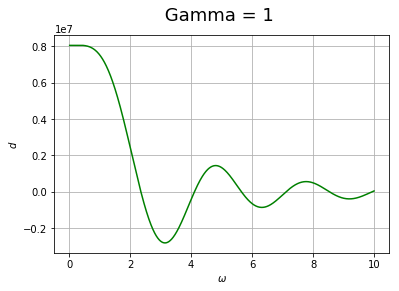

234

410

564

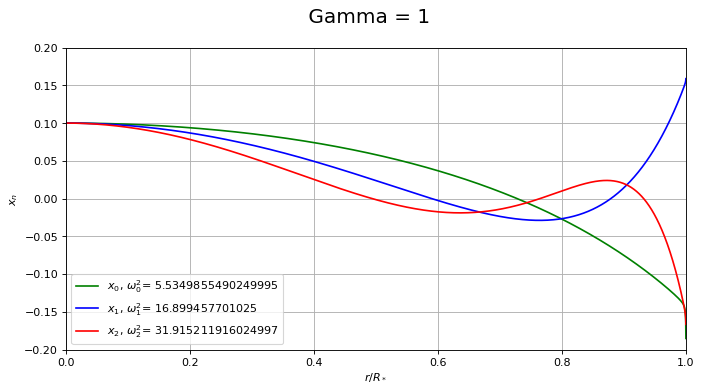

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

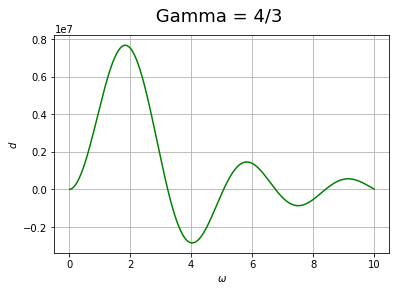

322

506

676

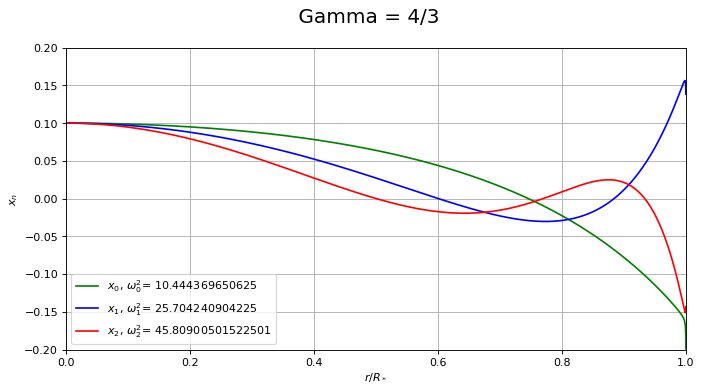

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

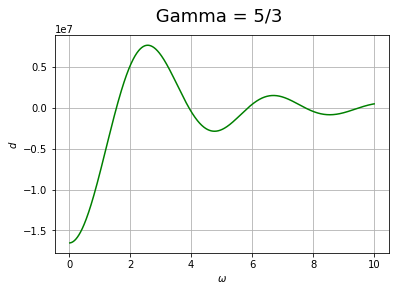

154

391

586

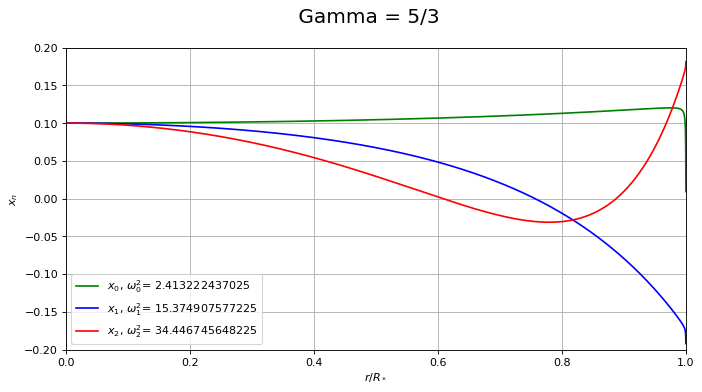

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [37]:
# Run the programm for a variety of adiabatic indexes

gaArray = np.array([1.0/3.0, 2.0/3.0, 1 , 4.0/3.0, 5.0/3.0])
gaA = len(gaArray)

for i in range(0,gaA):
    freq_function(gaArray[i])

### 6. Try to estimate the deformation of the Earth as it is given by the Roche model. Compare the result with the actual ellipticity of the Earth.

<IPython.core.display.Math object>

<IPython.core.display.Math object>

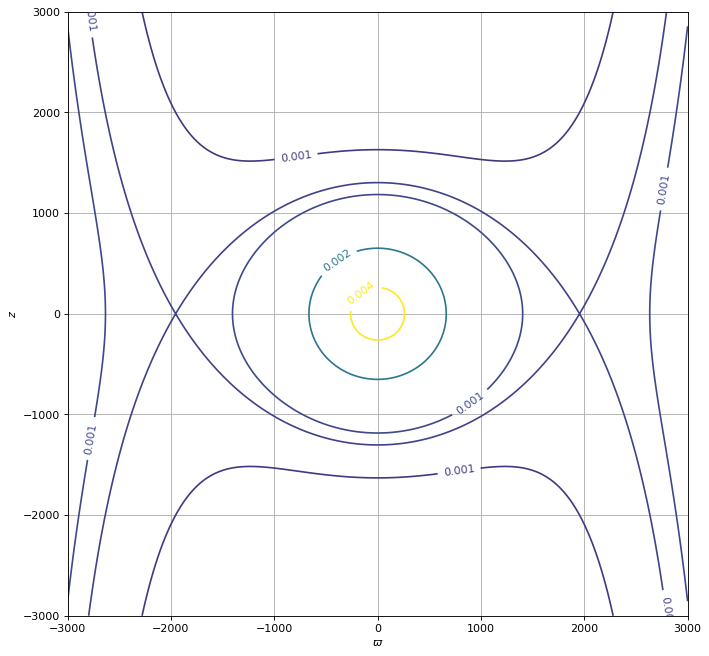

In [50]:
from ipykernel import kernelapp as app
from matplotlib import pyplot as plt    
import numpy as np                      
import math as Math
import csv
from IPython.display import display, Math, Latex


# Roche Model for Earth's rotation

xy_lim = 3000

x_vals = np.linspace(-xy_lim, xy_lim, 2001)
y_vals = np.linspace(-xy_lim, xy_lim, 2001)
r_pol, r_eq = np.meshgrid(x_vals, y_vals)

# display(r_eq)

omega_rot = 0.00001157407  # earth's omega

display(Math(r'\Omega_{earth} ='+str(omega_rot)))

V_eff = 1/np.sqrt(r_pol**2.0+r_eq**2)+(omega_rot**2.0/2.0)*r_eq**2.0

V_eff_cr = 1/pow(omega_rot,-2.0/3.0)\
                    +(omega_rot**2.0/2.0)*pow(omega_rot,-4.0/3.0)

#display(V_eff_cr)
display(Math(r'V_{cr} ='+str(V_eff_cr)))

plt.figure(figsize=(10, 10), dpi=80)

Rosh_cs = plt.contour(r_eq, r_pol, V_eff, (0.9*omega_rot, omega_rot, 1.1*omega_rot, 53*omega_rot, \
                                           V_eff_cr, 1.1*V_eff_cr, 2*V_eff_cr, 5*V_eff_cr))

# Rosh_cs = plt.contour(r_eq, r_pol, V_eff, 5)

plt.clabel(Rosh_cs, fontsize=10)

plt.xlabel(r'$\varpi$')
plt.ylabel(r'$z$')

plt.grid()   
plt.show() 

### 8. Calculate the ellipticity profile inside the stars for different polytropes. What do you observe? How is this related to what you found about the different mass distributions of different polytopes?

In [12]:
from ipykernel import kernelapp as app
from matplotlib import pyplot as plt    # For plotting things
import numpy as np                      # For mathematical/numerical applications
from scipy.integrate import odeint      # For integrating ODEs
from scipy import optimize
from fractions import Fraction
import sys
import warnings
if not sys.warnoptions: 
    warnings.simplefilter("ignore")

In [105]:
# First we construct our equilibrium model. function for different n values
l = 1.0
K = 1.0

def starLE(y, r, n, l):
     return (-pow(y[1],n)*r**2.0, l*y[0]/r**2.0,)  

def rotStar(y,  r, rho_m, G):
     return -G*(6.0*rho_m*(y+1.0)+y*(y-1.0)-6.0)/r 
    
def ellipticity_func(n):
    G = 1.0

    alpha = pow((1.0+n)*K/(G*4.0*np.pi),0.5) 
    y0 = (0.0, 1.0)     # This is the initial conditions vector (w_c, \theta_c)
    r = np.linspace(0, 4, 5001)     # This is an np.array object that creates the 
                                       # integration grid
    dr=r[1]-r[0]
    #display(dr)
    
    
    # ========================================================================================== #
    # Here we go straight to calculating the first point

    y1 = (-(1.0/3.0)*dr**3.0, 1.0-(1.0/6.0)*dr**2.0)
    #display(y1)

    r1 = np.linspace(dr, 4, 5001)                   
    soln10 = odeint(starLE, y1, r1, args =(n, l)) 

    y01 = np.array([[y0[0], y0[1]]])                
    r0 = np.array([0.0])                        
    # display(r0.shape)
    # display(r1.shape)

    #y0 = [0.0, 1.0]

    r = np.hstack([r0,r1])
    # display(r)

    sol_n10 = np.vstack([y01,soln10])
    #display(sol_n10)    
    solmin = np.min(sol_n10[:,1])
    solmin_i = np.argmin(sol_n10[:,1]) 
    #display(solmin,solmin_i)
    
    # here we check if desinty goes negative or not. If not procceed to calculations until the lower value.
    
    if solmin<0:
        i=0
        while list(sol_n10[:, 1])[i]>0 :
            i=i+1
        r_max_in = i
    else:
        r_max_in = solmin_i
        
    grid = r_max_in

    #display(r_max_in)
    #display(sol_n10[r_max_in, 1])

    rho_10_eq = pow(sol_n10[:, 1],n)
    P_10_eq = K*pow(sol_n10[:, 1],1.0+1.0/n)
    m_10_eq = - 4.0*np.pi*pow(alpha,3.0)*sol_n10[:, 0]
    r_10_eq = alpha*r


    rho_10_m = [1.0]
    
    i=1
    while i < r_max_in+1 :
        rho_10_m.append(-pow(sol_n10[i, 1],n)*r[i]**3.0/(3.0*sol_n10[i, 0])) 
        i=i+1

    #display(rho_10_m )    

    M_tot = m_10_eq[r_max_in]
    R_tot = r_10_eq[r_max_in]

    # Here we will solve Radau's equation.
    r1 = r_10_eq[0:r_max_in+1]

    #rho_10_m_Int = interp1d(r1, rho_10_m, kind='cubic')

    dr = r_10_eq[1]-r_10_eq[0]
    #display(dr)
    y0 = (0.01)

    y1 = y0

    #r1 = r_10_eq[2:r_max_in+1]

    #soln10_rot = odeint(rotStar, y1, r2, \
    #     args =(rho_10_m_Int, G))

    # ========================================================================================== #
    eta_rot = [0.0]
    x_rot = [0.0]

    eta_rot.append(0.0)
    x_rot.append(dr)

    j=2
    while j < r_max_in:
        rho_10_m2 = rho_10_m[j] 
        r2 = r1[j-1:j+1]
        G = 1.0
        #display(rho_10_m2)

        soln10_rot = odeint(rotStar, y1, r2, args =(rho_10_m2, G))
        y1 = (soln10_rot[1])
        eta_rot.append(soln10_rot[1])
        x_rot.append(r2[1])
        j=j+1
    
    #----------------------------------------------------------#


    x_rot_2 = [x_rot[-1]]

    ell_int = [0.0]
    ell_int_m = 0.0

    i=len(eta_rot)-1
    while i > 1:
        ell_int_m = ell_int_m +\
             (eta_rot[i]/x_rot[i]+ eta_rot[i-1]/x_rot[i-1])*\
                          (x_rot[i-1]-x_rot[i])/2.0
        ell_int.append(ell_int_m)
        x_rot_2.append(x_rot[i-1])
        i=i-1

    ell_ratio = np.exp(ell_int)

    dTitle2 =  'n = ' + str(n)
    plt.plot(x_rot_2/R_tot, ell_ratio,label=dTitle2)
    plt.xlim(0.0, 1.0)
    plt.ylim(0.0, 1.01)


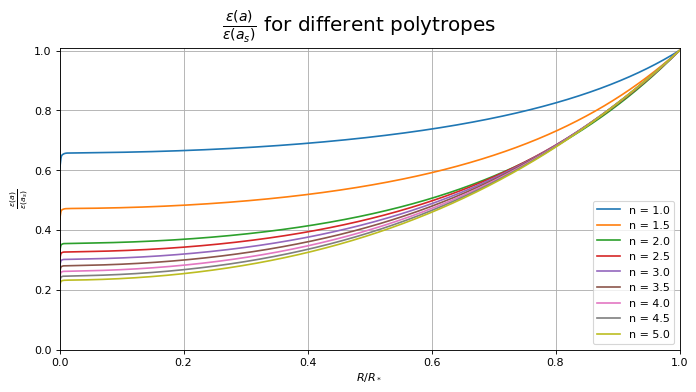

In [107]:
# Calculate ellipticity for a variety of n

nArray = np.array([1, 3/2, 2, 5/2, 3, 7/2, 4, 9/2, 5])
nA = len(nArray)

plt.figure(figsize=(10, 5), dpi=80)
plt.suptitle(r'$\frac{\epsilon(a)}{\epsilon(a_s)}$ for different polytropes', fontsize=18)

for i in range(0,nA):
    ellipticity_func(nArray[i])
    
plt.legend(loc='best')
plt.xlabel(r'$R/R_*$')
plt.ylabel(r'$\frac{\epsilon(a)}{\epsilon(a_s)}$')
plt.grid()
plt.show()